In [101]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import keras
from IPython.display import Image, display
from tensorflow.python.framework import ops



!pip3 install tensorflow -qqq
!pip3 install wandb -qqq
import wandb
!wandb login
from wandb.keras import WandbCallback

wandb: Currently logged in as: cs6910krsrd (use `wandb login --relogin` to force relogin)


In [71]:
PROJECT_NAME = "CS6910 ASSIGNMENT 2"
cls={'Amphibia':0,
     'Animalia':1,
     'Arachnida':2,
     'Aves':3,
     'Fungi':4,
     'Insecta':5,
     'Mammalia':6,
     'Mollusca':7,
     'Plantae':8,
     'Reptilia':9}

In [72]:
from tensorflow.keras.preprocessing import image

run = wandb.init(project=PROJECT_NAME, job_type="inference")
# use the latest version of the model
model_at = run.use_artifact('cs6910krsrd/CS6910 ASSIGNMENT 2/CNN:v8', type='model')
# rohithd/uncategorized/CNN:v0', type='model'
# download the directory in which the model is saved
model_dir= model_at.download()
print("model: ", model_dir)
model = tf.keras.models.load_model(model_dir)



model:  ./artifacts/CNN:v8


In [73]:

test_data_at = run.use_artifact('krsrinivas/CS6910 ASSIGNMENT 2/test_raw_data_2000:v0', type='raw_data')
test_dir = test_data_at.download()


wandb: Downloading large artifact test_raw_data_2000:v0, 604.34MB. 2000 files... Done. 0:0:0


In [74]:

imgs = []
true_pred=[]
class_labels = os.listdir(test_dir)
for l in class_labels:
  if l.startswith("."):
    continue
  imgs_per_class = os.listdir(os.path.join(test_dir, l))
  for img in imgs_per_class:
    img_path = os.path.join(test_dir, l, img)
    if img_path[-4:]!=".jpg":
      continue
    img = image.load_img(img_path, target_size=(229, 229))
    img = image.img_to_array(img)
    # don't forget to rescale test images to match the range of inputs
    # to the network
    img = np.expand_dims(img/255.0, axis=0)
    imgs.append(img)
    true_pred.append(cls[l])
imgs = np.vstack(imgs)

In [31]:

preds = {}
classes = model.predict(imgs, batch_size=32)
for c in classes:
  class_id = np.argmax(c)
  if class_id in preds:
    preds[class_id] += 1
  else:
    preds[class_id] = 1

# print the counts of predicted labels as a quick sanity check
# note that for tiny/medium datasets, this won't be very meaningful
print(preds)
run.finish()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
{1: 174, 5: 130, 3: 152, 9: 314, 8: 250, 6: 288, 2: 198, 4: 313, 0: 117, 7: 64}


In [75]:
run.finish()

In [8]:
model.save('bestmodel.h5')


In [7]:
true_pred_vector=np.zeros((np.shape(true_pred)[0],10))
for i,true_val in enumerate(true_pred):
  true_pred_vector[i,true_val]=1
true_pred_vector=np.array(true_pred_vector)

In [32]:
model.evaluate(imgs,true_pred_vector)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
63/63 [==============================] - 27s 426ms/step - loss: 1.7113 - accuracy: 0.4065


[1.711300015449524, 0.4065000116825104]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


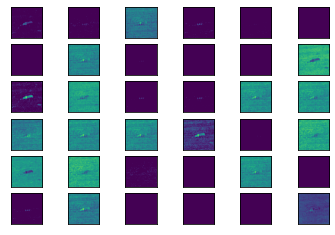

In [9]:
from numpy import random
from keras.models import Model

modelConv1=Model(inputs=model.inputs, outputs=model.layers[0].output)

# take a random image "img"
img= np.expand_dims(imgs[random.randint(0,2000)], axis=0)

preds=modelConv1.predict(img,batch_size=32)
square = 6
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(preds[0, :, :, ix-1], cmap='viridis')
		ix += 1
# show the figure
plt.show()

In [98]:
layer_name="conv2d_4"

layer = model.get_layer(name=layer_name)
feature_extractor = Model(inputs=model.inputs, outputs=layer.output)

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

def register_guidedrelu():
  if "GuidedRelu" not in ops._gradient_registry._registry:
    @tf.RegisterGradient("GuidedRelu")
    def _GuidedReluGrad(op, grad):
      gate_f = tf.cast(op.outputs[0] > 0, "float32") #for f^l > 0
      gate_R = tf.cast(grad > 0, "float32") #for R^l+1 > 0
      return gate_f * gate_R * grad

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.compat.v1.get_default_graph().gradient_override_map({'Relu': 'GuidedRelu'}):
      with tf.GradientTape() as tape:
          tape.watch(img)
          loss = compute_loss(img, filter_index)
          # Compute gradients.
          grads = tape.gradient(loss, img)
      
    return loss, grads

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img) * 0.25

def visualize_filter(filter_index,img):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    loss=0
    img=np.expand_dims(img, axis=0)
    loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

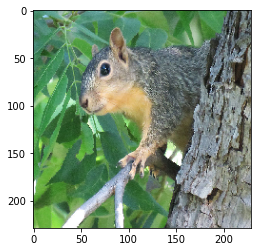

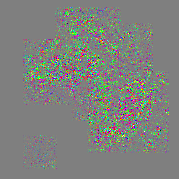

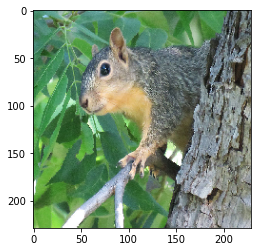

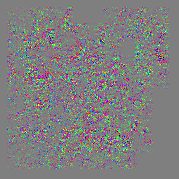

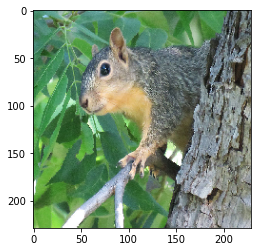

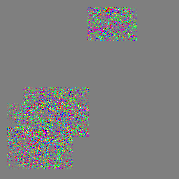

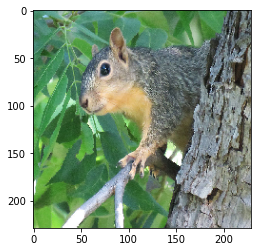

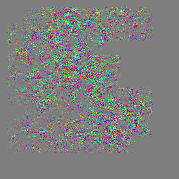

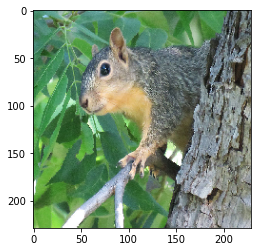

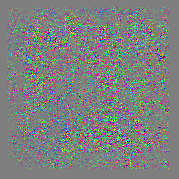

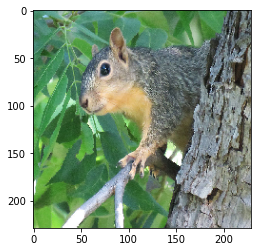

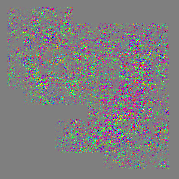

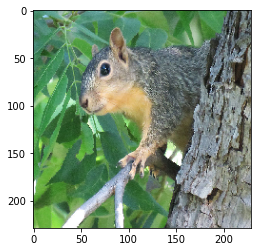

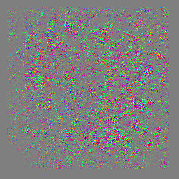

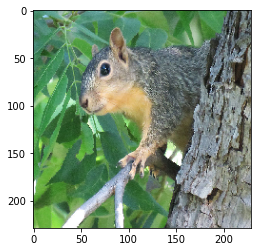

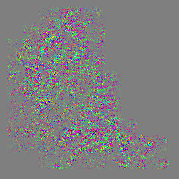

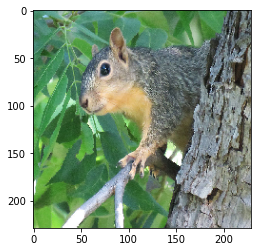

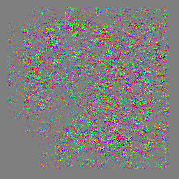

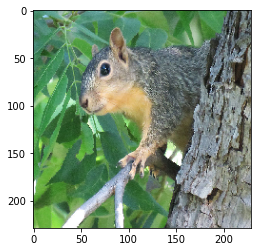

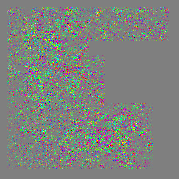

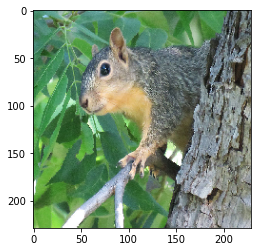

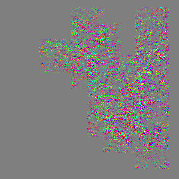

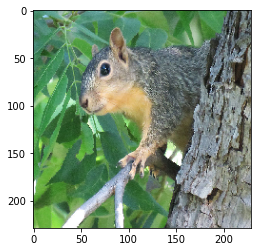

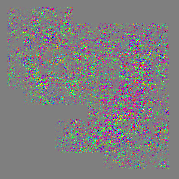

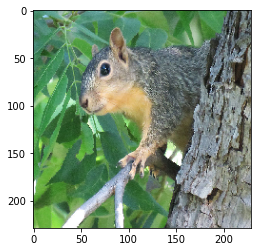

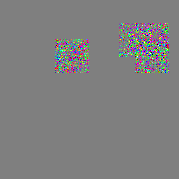

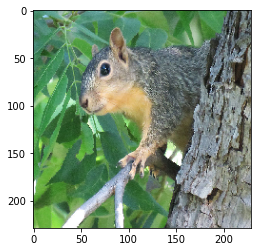

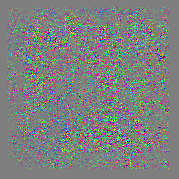

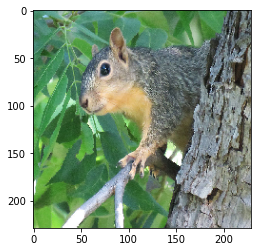

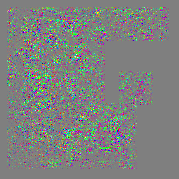

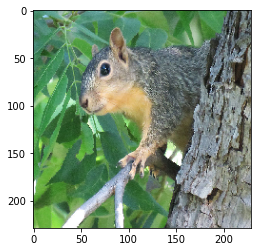

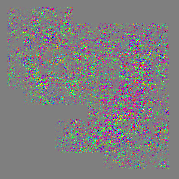

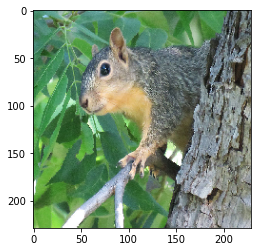

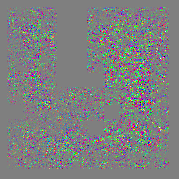

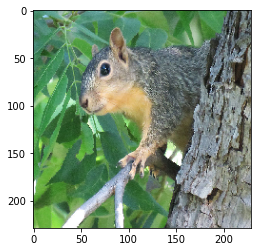

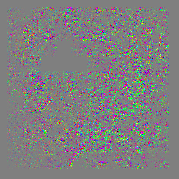

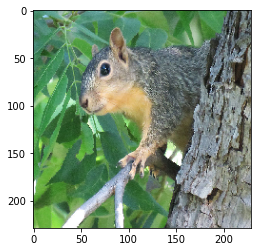

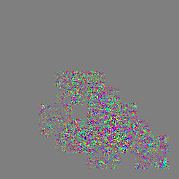

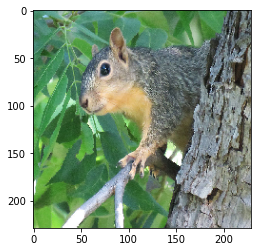

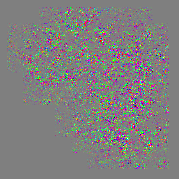

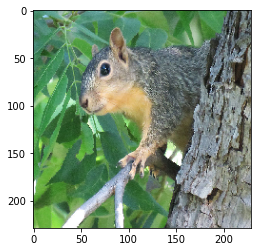

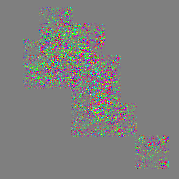

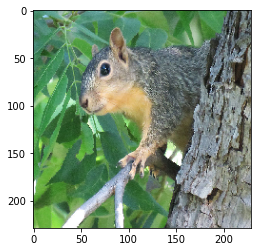

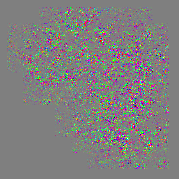

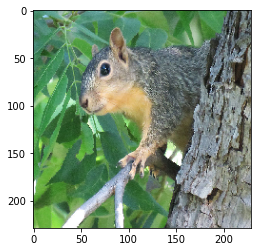

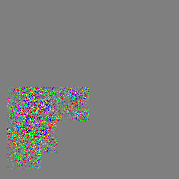

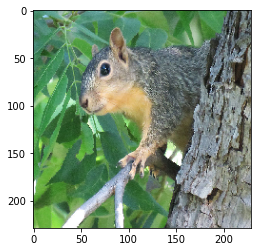

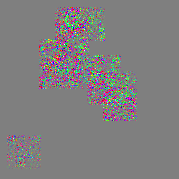

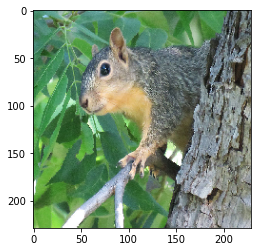

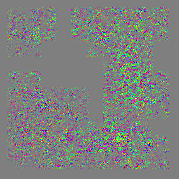

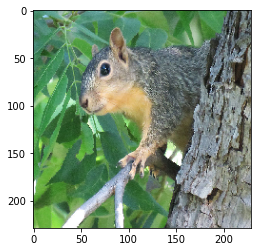

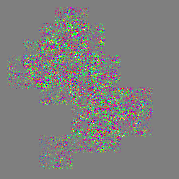

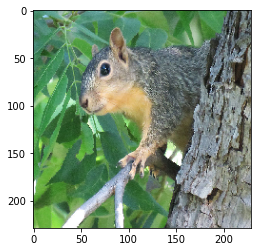

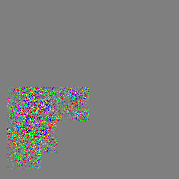

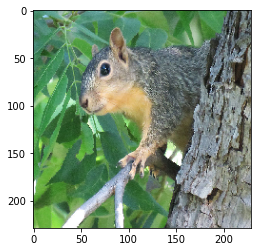

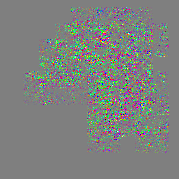

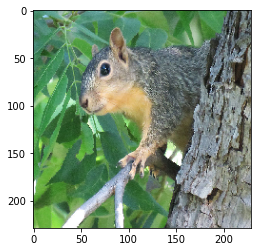

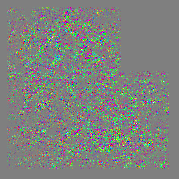

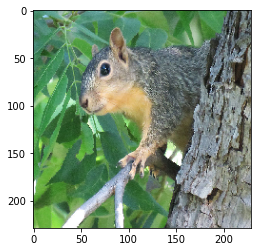

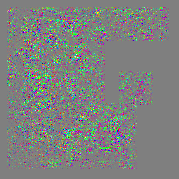

In [103]:
register_guidedrelu()
img_width,img_height=229,229

for i in range(30):
  a=550#np.random.randint(2000)
  plt.imshow(imgs[a])
  plt.show()
  loss, img = visualize_filter(np.random.randint(100),imgs[a])
  keras.preprocessing.image.save_img("0.png", img)
  display(Image("0.png"))
